**학습 데이터 (user_id : 10000 ~ 24999, 15000명)**

- `train_err_data.csv` : 시스템에 발생한 에러 로그

- `train_quality_data.csv` : 시스템 퀄리티 로그

- `train_problem_data.csv` : 사용자 불만 및 불만이 접수된 시간


**테스트 데이터(user_id : 30000 ~ 44998, 14999명)**

- `test_err_data.csv` : 시스템에 발생한 에러 로그

- `test_quality_data.csv` : 시스템 퀄리티 로그

- `sample_submission.csv` : 사용자 불만 확률(0~1) (제출용)

## Import Library & Read Data

In [1]:
import os 
import re
import numpy as np 
import pandas as pd
from tqdm import tqdm
from datetime import datetime
from rich import print

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
%matplotlib inline

import warnings 
warnings.filterwarnings(action='ignore')

In [2]:
for file in os.listdir('dataset'):
    print(file)

In [3]:
train_err = pd.read_csv('dataset/train_err_data.csv')

train_problem = pd.read_csv('dataset/train_problem_data.csv')
train_quality = pd.read_csv('dataset/train_quality_data.csv')

test_err = pd.read_csv('dataset/test_err_data.csv')
test_quality = pd.read_csv('dataset/test_quality_data.csv')

submission = pd.read_csv('dataset/sample_submission.csv')

In [4]:
print(f"{'-'*10}Train Dataset Shape{'-'*10}")
print('[bold magenta]Train_Error:{}[/bold magenta]'.format(train_err.shape))
print('[bold magenta]Train_Problem:{}[/bold magenta]'.format(train_problem.shape))
print('[bold magenta]Train_Quality:{}[/bold magenta]\n'.format(train_quality.shape))

print(f"{'-'*10}Test Dataset Shape{'-'*10}")
print('[bold cyan]Test Error:{}[/bold cyan]'.format(test_err.shape))
print('[bold cyan]Test Quality:{}[/bold cyan]\n'.format(test_quality.shape))

print(f"{'-'*10}Submisson Dataset Shape{'-'*10}")
print('[bold blue]Submission :{}[/bold blue]'.format(submission.shape))

## Simple Feature Engineering

In [5]:
min_day = datetime.strptime('2020-10-31', '%Y-%m-%d').date()

def make_datetime(df):
    df['time'] = df['time'].apply(lambda x: datetime.strptime(str(x), '%Y%m%d%H%M%S'))
    df['date'] = df['time'].apply(lambda x: x.date())
    df['days'] = df['date'].apply(lambda x: (x-min_day).days)
    df['week'] = df['time'].apply(lambda x: x.week)
#     df['hour'] = df['time'].apply(lambda x: x.hour)
    return df 

In [6]:
import multiprocessing
from multiprocessing import Pool


def parallelize_dataframe(df, func, n_cores=4):
    df_split = np.array_split(df, n_cores)
    pool = Pool(n_cores)
    df = pd.concat(pool.map(func, df_split))
    pool.close()
    pool.join()
    return df

In [7]:
train_err = parallelize_dataframe(train_err, make_datetime, n_cores=8)
train_quality = parallelize_dataframe(train_quality, make_datetime, n_cores=4)
train_problem = parallelize_dataframe(train_problem, make_datetime, n_cores=4)

## EDA

<AxesSubplot:xlabel='errtype', ylabel='counts'>

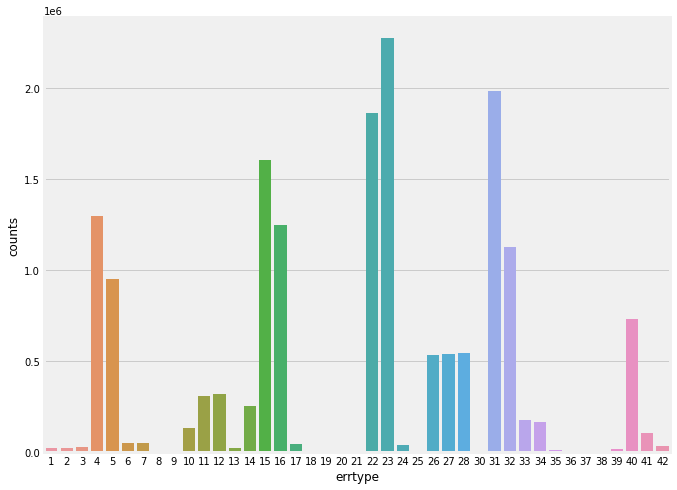

In [8]:
plt.figure(figsize=(10,8))

(train_err
 .filter(['errtype'])
 .value_counts()
 .reset_index(name='counts')
 .pipe((sns.barplot, 'data'),
       x='errtype', y='counts')
)

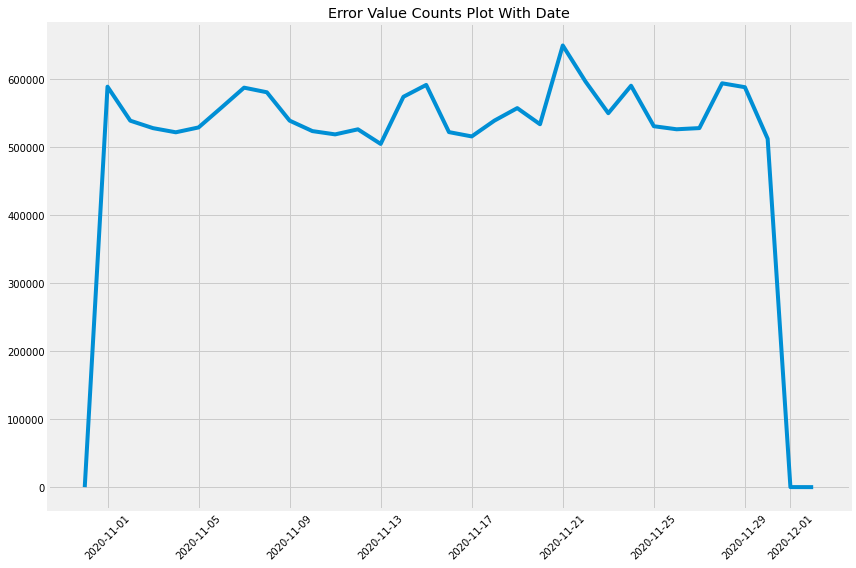

In [9]:
plt.figure(figsize=(12,8))

train_err['date'].value_counts().sort_index().plot()

plt.xticks(rotation=45)
plt.title('Error Value Counts Plot With Date')
plt.tight_layout()

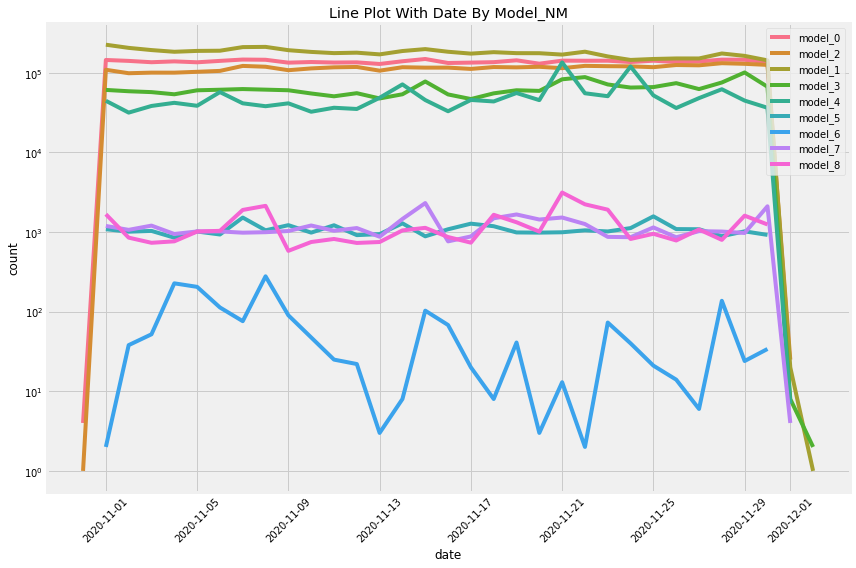

In [10]:
plt.figure(figsize=(12,8))

(train_err
 .filter(['model_nm', 'date'])
 .groupby(['date','model_nm'])
 .size()
 .reset_index(name='count')
 .pipe((sns.lineplot, 'data'),
       x='date', y='count', hue='model_nm')
)
plt.xticks(rotation=45)
plt.yscale('log')
plt.legend(loc='upper right')
plt.title('Line Plot With Date By Model_NM')
plt.tight_layout()

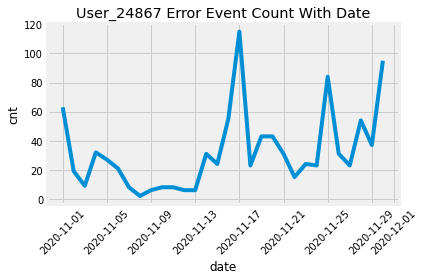

In [11]:
uid = 24867

(train_err
 .query('user_id==@uid')
 .groupby('date')
 .size()
 .reset_index(name='cnt')
 .pipe((sns.lineplot, 'data'),
      x='date', y='cnt')
)
plt.xticks(rotation=45)
plt.title(f'User_{uid} Error Event Count With Date')
plt.tight_layout()

In [12]:
err_user = list(set(train_err['user_id'].values))
quality_user = list(set(train_quality['user_id'].values))
problem_user = list(set(train_problem['user_id'].values))

In [13]:
plt.figure(figsize=(10,8))

(train_err
 .query('user_id==@quality_user')
 .filter(['errcode_type'])
 .value_counts()
 .reset_index(name='counts')
 .pipe((sns.barplot, 'data'),
       x='errcode_type', y='counts')
)

ValueError: No group keys passed!

<Figure size 720x576 with 0 Axes>

In [ ]:
# df = train_quality.groupby('model_nm')[quality_col].mean().reset_index()

# sns.scatterplot(df['quality_0'], 
#              hue=df['model_nm'])

## Feature Engineering

In [8]:
def description(df):
    print(df.shape)
    summary = pd.DataFrame()
    summary['name'] = df.dtypes.index
    summary['dtype'] = df.dtypes.values
    summary['missing'] = df.isnull().sum().values
    summary['uniques'] = df.nunique().values
#     summary['min'] = df.min().values
#     summary['max'] = df.max().values
    return summary

### Train_Error

In [10]:
description(train_err)

,name,dtype,missing,uniques
0,user_id,int64,0,15000
1,time,datetime64[ns],0,2566163
2,model_nm,object,0,9
3,fwver,object,0,37
4,errtype,int64,0,41
5,errcode,object,1,2805
6,date,object,0,33
7,days,int64,0,33
8,week,int64,0,6


In [ ]:
# train_err = train_err.drop(['fwver'], axis=1)

#### Model_NM

In [94]:
# ## 유저별 일별 에러타입 합산 코드

train_modelnm_cnt = train_err.groupby(['user_id','days'])['model_nm'].nunique().reset_index()
train_modelnm_cnt = train_modelnm_cnt.pivot_table(index='user_id', 
                                                  columns='days',
                                                  values='model_nm', 
                                                  fill_value=0).reset_index()

train_modelnm_cnt.columns.name=None
train_modelnm_cnt.columns = ['user_id'] + ['day{}_modelnm_cnt'.format(i) for i in train_modelnm_cnt.columns[1:]]
train_modelnm_cnt.head()

,user_id,day0_modelnm_cnt,day1_modelnm_cnt,day2_modelnm_cnt,day3_modelnm_cnt,day4_modelnm_cnt,day5_modelnm_cnt,day6_modelnm_cnt,day7_modelnm_cnt,day8_modelnm_cnt,...,day23_modelnm_cnt,day24_modelnm_cnt,day25_modelnm_cnt,day26_modelnm_cnt,day27_modelnm_cnt,day28_modelnm_cnt,day29_modelnm_cnt,day30_modelnm_cnt,day31_modelnm_cnt,day32_modelnm_cnt
0,10000,0,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,0,0
1,10001,0,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,0,0
2,10002,0,1,1,1,1,1,1,1,1,...,1,1,1,1,1,0,1,1,0,0
3,10003,0,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,0,0
4,10004,0,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,0,0


#### Err Type

In [221]:
train_err.head()

,user_id,time,model_nm,fwver,errtype,errcode,date,days,week,errcode_type
0,10000,2020-11-01 02:56:16,model_3,05.15.2138,15,1,2020-11-01,1,44,0
1,10000,2020-11-01 03:03:09,model_3,05.15.2138,12,1,2020-11-01,1,44,0
2,10000,2020-11-01 03:03:09,model_3,05.15.2138,11,1,2020-11-01,1,44,0
3,10000,2020-11-01 05:05:14,model_3,05.15.2138,16,1,2020-11-01,1,44,0
4,10000,2020-11-01 05:05:15,model_3,05.15.2138,4,0,2020-11-01,1,44,1


In [226]:
train_err.shape

(16554663, 10)

In [225]:
train_err.drop_duplicates().shape

(15368002, 10)

In [230]:
train_err.loc[train_err.duplicated()==True].head(40)

,user_id,time,model_nm,fwver,errtype,errcode,date,days,week,errcode_type
139,10000,2020-11-13 14:07:42,model_3,05.15.2138,16,1,2020-11-13,13,46,0
318,10001,2020-11-01 02:04:15,model_2,04.33.1185,15,1,2020-11-01,1,44,0
332,10001,2020-11-02 00:23:10,model_2,04.33.1185,5,B-A8002,2020-11-02,2,45,3
334,10001,2020-11-02 00:23:11,model_2,04.33.1185,5,B-A8002,2020-11-02,2,45,3
335,10001,2020-11-02 00:23:11,model_2,04.33.1185,5,B-A8002,2020-11-02,2,45,3
338,10001,2020-11-02 00:23:18,model_2,04.33.1185,5,B-A8002,2020-11-02,2,45,3
341,10001,2020-11-02 02:01:59,model_2,04.33.1185,14,14,2020-11-02,2,45,6
342,10001,2020-11-02 02:01:59,model_2,04.33.1185,14,14,2020-11-02,2,45,6
343,10001,2020-11-02 02:01:59,model_2,04.33.1185,14,14,2020-11-02,2,45,6
344,10001,2020-11-02 02:01:59,model_2,04.33.1185,14,14,2020-11-02,2,45,6


In [234]:
(train_err
 .query('user_id==10005')
 .query('days>=2')
).head(40)

,user_id,time,model_nm,fwver,errtype,errcode,date,days,week,errcode_type
4097,10005,2020-11-02 00:01:55,model_0,04.22.1750,26,1,2020-11-02,2,45,0
4098,10005,2020-11-02 03:38:48,model_0,04.22.1750,15,1,2020-11-02,2,45,0
4099,10005,2020-11-02 03:51:14,model_0,04.22.1750,15,1,2020-11-02,2,45,0
4100,10005,2020-11-02 03:51:14,model_0,04.22.1750,33,2,2020-11-02,2,45,8
4101,10005,2020-11-02 03:51:17,model_0,04.22.1750,15,1,2020-11-02,2,45,0
4102,10005,2020-11-02 03:51:32,model_0,04.22.1750,11,1,2020-11-02,2,45,0
4103,10005,2020-11-02 03:51:32,model_0,04.22.1750,12,1,2020-11-02,2,45,0
4104,10005,2020-11-02 03:51:44,model_0,04.22.1750,15,1,2020-11-02,2,45,0
4105,10005,2020-11-02 03:51:56,model_0,04.22.1750,22,1,2020-11-02,2,45,0
4106,10005,2020-11-02 14:28:20,model_0,04.22.1750,26,1,2020-11-02,2,45,0


In [224]:
## 유저별 에러별 합산 코드

# train_err['err_cnt'] = train_err['errtype']

train_errrtype_cnt = train_err.pivot_table(index='user_id', 
                                           columns='errtype', 
                                           values='time', 
                                           aggfunc='count', 
                                           fill_value=0).reset_index()

train_errrtype_cnt.columns.name=None
train_errrtype_cnt.columns = ['user_id'] + ['errtype_' + str(i) for i in range(1, 43) if i!=29]
train_errrtype_cnt.head()

,user_id,errtype_1,errtype_2,errtype_3,errtype_4,errtype_5,errtype_6,errtype_7,errtype_8,errtype_9,...,errtype_33,errtype_34,errtype_35,errtype_36,errtype_37,errtype_38,errtype_39,errtype_40,errtype_41,errtype_42
0,10000,0,0,8,104,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,10001,0,0,0,0,53,1,1,0,0,...,10,18,0,1,1,0,0,113,56,1
2,10002,0,0,2,132,1,2,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,10003,0,0,0,0,2,1,1,0,0,...,8,0,0,1,1,2,0,17,1,0
4,10004,0,0,0,1,0,3,4,0,0,...,16,0,0,1,1,0,0,4,0,2


In [96]:
# ## 유저별 일별 에러타입 합산 코드

train_errtype_cnt_byday = train_err.groupby(['user_id','days'])['errtype'].nunique().reset_index()
train_errtype_cnt_byday = train_errtype_cnt_byday.pivot_table(index='user_id', 
                                                              columns='days',
                                                              values='errtype', 
                                                              fill_value=0).reset_index()

train_errtype_cnt_byday.columns.name=None
train_errtype_cnt_byday.columns = ['user_id'] + ['day{}_errtype_cnt'.format(i) for i in train_errtype_cnt_byday.columns[1:]]
train_errtype_cnt_byday.head()

,user_id,day0_errtype_cnt,day1_errtype_cnt,day2_errtype_cnt,day3_errtype_cnt,day4_errtype_cnt,day5_errtype_cnt,day6_errtype_cnt,day7_errtype_cnt,day8_errtype_cnt,...,day23_errtype_cnt,day24_errtype_cnt,day25_errtype_cnt,day26_errtype_cnt,day27_errtype_cnt,day28_errtype_cnt,day29_errtype_cnt,day30_errtype_cnt,day31_errtype_cnt,day32_errtype_cnt
0,10000,0,6,4,9,4,6,4,9,4,...,4,4,4,4,6,4,8,4,0,0
1,10001,0,8,9,7,6,14,7,6,6,...,8,6,4,12,8,8,16,9,0,0
2,10002,0,5,4,7,4,4,3,6,4,...,3,4,6,4,6,0,5,4,0,0
3,10003,0,6,7,6,4,12,4,2,8,...,7,7,4,5,9,6,9,4,0,0
4,10004,0,13,5,9,5,3,9,6,9,...,5,8,11,6,10,6,10,6,0,0


In [97]:
# ## 유저별 일별 에러타입 합산 코드

train_errtype_sum_byday = train_err.pivot_table(index='user_id', 
                                                columns=['errtype', 'days'],
                                                values='date', 
                                                aggfunc='count',
                                                fill_value=0).reset_index()

train_errtype_sum_byday.columns.name=None
train_errtype_sum_byday.columns = ['user_id'] + ['day{}_errtype{}'.format(j, i) for i, j in train_errtype_sum_byday.columns[1:]]
train_errtype_sum_byday.head()

,user_id,day1_errtype1,day2_errtype1,day3_errtype1,day4_errtype1,day5_errtype1,day6_errtype1,day7_errtype1,day8_errtype1,day9_errtype1,...,day21_errtype42,day22_errtype42,day23_errtype42,day24_errtype42,day25_errtype42,day26_errtype42,day27_errtype42,day28_errtype42,day29_errtype42,day30_errtype42
0,10000,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,10001,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,10002,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,10003,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,10004,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0


#### Err Code

In [98]:
errcode_type = {code:idx for idx, code in enumerate(list(train_err['errcode'].value_counts()[:20].index))}
errcode_type

{'1': 0,
 '0': 1,
 'connection timeout': 2,
 'B-A8002': 3,
 '80': 4,
 '79': 5,
 '14': 6,
 'active': 7,
 '2': 8,
 '84': 9,
 '85': 10,
 'standby': 11,
 'NFANDROID2': 12,
 'connection fail to establish': 13,
 '3': 14,
 '90': 15,
 '89': 16,
 'S-61001': 17,
 '95': 18,
 '94': 19}

In [99]:
def case_errcode(x):
    try:
        return errcode_type[x]
    except:
        return 20

In [100]:
train_err['errcode_type'] = train_err['errcode'].apply(lambda x: case_errcode(x))

In [101]:
# 유저별 에러코드 합산 코드

train_errcode_cnt = train_err.pivot_table(index='user_id', 
                                          columns='errcode_type', 
                                          values='days', 
                                          aggfunc='count', 
                                          fill_value=0).reset_index()

train_errcode_cnt.columns.name=None
train_errcode_cnt.columns = ['user_id'] + ['errcode_' + str(i) for i in train_errcode_cnt.columns[1:]]
train_errcode_cnt.head()

,user_id,errcode_0,errcode_1,errcode_2,errcode_3,errcode_4,errcode_5,errcode_6,errcode_7,errcode_8,...,errcode_11,errcode_12,errcode_13,errcode_14,errcode_15,errcode_16,errcode_17,errcode_18,errcode_19,errcode_20
0,10000,212,104,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,10001,1274,183,0,53,0,0,16,126,7,...,625,56,0,5,0,0,0,0,0,20
2,10002,172,132,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
3,10003,229,42,7,1,0,0,3,12,3,...,0,1,0,4,0,0,1,0,0,3
4,10004,529,98,104,0,0,0,9,7,14,...,5,0,1,4,0,0,0,0,0,6


In [102]:
# ## 유저별 일별 에러타입 합산 코드

train_errcode_cnt_byday = train_err.groupby(['user_id','days'])['errcode'].nunique().reset_index()

train_errcode_cnt_byday = train_errcode_cnt_byday.pivot_table(index='user_id', 
                                                              columns='days',
                                                              values='errcode', 
                                                              fill_value=0).reset_index()

train_errcode_cnt_byday.columns.name=None
train_errcode_cnt_byday.columns = ['user_id'] + ['day{}_errcode_cnt'.format(i) for i in train_errcode_cnt_byday.columns[1:]]
train_errcode_cnt_byday.head()

,user_id,day0_errcode_cnt,day1_errcode_cnt,day2_errcode_cnt,day3_errcode_cnt,day4_errcode_cnt,day5_errcode_cnt,day6_errcode_cnt,day7_errcode_cnt,day8_errcode_cnt,...,day23_errcode_cnt,day24_errcode_cnt,day25_errcode_cnt,day26_errcode_cnt,day27_errcode_cnt,day28_errcode_cnt,day29_errcode_cnt,day30_errcode_cnt,day31_errcode_cnt,day32_errcode_cnt
0,10000,0,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,0,0
1,10001,0,3,6,4,3,6,3,3,4,...,5,4,3,7,5,5,8,7,0,0
2,10002,0,2,2,2,2,2,2,2,2,...,1,2,2,2,2,0,2,2,0,0
3,10003,0,3,3,3,2,6,2,1,3,...,3,2,2,2,4,3,3,2,0,0
4,10004,0,6,3,3,3,2,4,4,4,...,2,3,5,4,5,3,6,3,0,0


In [38]:
## 유저별 에러코드 타입에 따른 일별 합산 코드

train_errcode_sum_byday = train_err.pivot_table(index='user_id', 
                                                columns=['errcode_type', 'days'], 
                                                values='date', 
                                                aggfunc='count',
                                                fill_value=0).reset_index()

train_errcode_sum_byday.columns.name=None
train_errcode_sum_byday.columns = ['user_id'] + ['day{}_errcode{}_sum'.format(j, i) for i, j in train_errcode_sum_byday.columns[1:]]
train_errcode_sum_byday.head()

,user_id,day0_errcode0_sum,day1_errcode0_sum,day2_errcode0_sum,day3_errcode0_sum,day4_errcode0_sum,day5_errcode0_sum,day6_errcode0_sum,day7_errcode0_sum,day8_errcode0_sum,...,day23_errcode20_sum,day24_errcode20_sum,day25_errcode20_sum,day26_errcode20_sum,day27_errcode20_sum,day28_errcode20_sum,day29_errcode20_sum,day30_errcode20_sum,day31_errcode20_sum,day32_errcode20_sum
0,10000,0,7,5,16,3,6,5,16,5,...,0,0,0,0,0,0,0,0,0,0
1,10001,0,9,19,17,30,28,20,8,14,...,4,0,0,0,0,0,0,1,0,0
2,10002,0,4,7,9,7,5,4,7,7,...,0,0,0,0,0,0,0,0,0,0
3,10003,0,6,9,6,4,7,4,2,9,...,0,0,0,0,0,0,0,0,0,0
4,10004,0,16,12,35,17,8,21,13,22,...,0,0,1,0,0,0,0,0,0,0


#### Test Code

In [ ]:
# errcode_type = train_err[['user_id','errcode_type','days']].values

# errorcode = np.zeros((15000, 21, 33))
# for idx, types, days in tqdm(errcode_type):
#     errorcode[idx - 10000, types, days] += 1


# from collections import defaultdict

# errcode_dict = defaultdict(list)

# for user in tqdm(range(15000)):
#     for day in range(32):
#         a = errorcode[user,:,day].reshape(1,-1)
#         b = errorcode[user,:,day+1].reshape(1,-1)
#         c = cosine_similarity(a, b)[0][0]
#         errcode_dict[str(user+10000)].append(c)    


# filter_col = ['user_id'] + [f'errcode_cos_sim{i}' for i in range(32)]

# errcode_df = pd.DataFrame.from_dict(errcode_dict, orient="index").reset_index()
# errcode_df.columns = filter_col

In [ ]:
# train_x = pd.merge(train_x, user_quality, how='left', on='user_id')
# train_x = train_x.fillna(0)

In [ ]:
# train_err = train_err.groupby('user_id').apply(pd.DataFrame.sort_values, 'time').reset_index(drop=True)

In [ ]:
# model_nm = train_err.groupby(['user_id', 'week'])['model_nm'].apply(lambda x: len(x.unique())).reset_index()
# fwver = train_err.groupby(['user_id', 'week'])['fwver'].apply(lambda x: len(x.unique())).reset_index()
# errtype = train_err.groupby(['user_id', 'week'])['errtype'].apply(lambda x: len(x.unique())).reset_index()
# errcode = train_err.groupby(['user_id', 'week'])['errcode'].apply(lambda x: len(x.unique())).reset_index()

In [ ]:
# train_x = train_err[['user_id', 'week']].drop_duplicates().reset_index(drop=True)

# train_x = pd.merge(train_x, model_nm, how='inner', on=['user_id', 'week'])
# train_x = pd.merge(train_x, fwver, how='inner', on=['user_id', 'week'])
# train_x = pd.merge(train_x, errtype, how='inner', on=['user_id', 'week'])
# train_x = pd.merge(train_x, errcode, how='inner', on=['user_id', 'week'])

# train_x = train_x.pivot_table(index='user_id', columns='week')
# train_x.columns = ['{}_{}'.format(i, j) for i, j in train_x.columns]

# train_x = train_x.fillna(0)

# train_x.head()

### Train_Quality

In [235]:
train_quality = pd.read_csv('dataset/train_quality_data.csv')
train_quality = parallelize_dataframe(train_quality, make_datetime, n_cores=4)

In [64]:
train_quality = train_quality.drop(['quality_3', 'quality_4'], axis=1)

In [27]:
train_quality = train_quality.groupby('user_id').apply(pd.DataFrame.sort_values, 'time').reset_index(drop=True)

In [63]:
quality_col = [col for col in train_quality.columns if col.startswith('quality')]

def string2num(x):
    # (,)( )과 같은 불필요한 데이터 정제
    x = re.sub(r"[^0-9]+", '', str(x))
    if x =='':
        return 0
    else:
        return int(x)
    
for col in quality_col:
    train_quality[col] = train_quality[col].apply(lambda x: string2num(x))

In [22]:
fwver_model_dict = {'04.22': 'model_0',
                    '04.16': 'model_1',
                    '04.33': 'model_2',
                    '05.15': 'model_3',
                    '03.11': 'model_4',
                    '04.82': 'model_5',
                    '05.66': 'model_7',
#                     '10': 'model_6',
                    '04.73': 'model_8'}

In [23]:
def case_fwver(x):
    try:    
        return fwver_model_dict[x[:5]]
    except:
        return 'model_unk'

In [24]:
train_quality['model_nm'] = train_quality['fwver'].apply(lambda x: case_fwver(x))

#### Quality_Case

In [112]:
train_avg_quality = train_quality.groupby('user_id')[quality_col].mean().reset_index()
train_avg_quality.head()

,user_id,quality_0,quality_1,quality_2,quality_5,quality_6,quality_7,quality_8,quality_9,quality_10,quality_11,quality_12
0,10000,0.000000,0.000000,0.000000,0.500000,0.000000,0.000000,0.0,0.000,6.000,0.000000,0.0
1,10002,0.416667,0.020833,0.312500,0.343750,0.500000,5.750000,0.0,0.125,3.875,0.020833,0.0
2,10004,0.833333,0.083333,0.833333,0.250000,3.708333,43.500000,0.0,0.000,2.000,0.083333,0.0
3,10005,4.166667,0.416667,4.166667,0.833333,1.916667,18.000000,0.0,0.000,5.000,0.416667,0.0
4,10006,0.000000,0.000000,0.000000,0.333333,0.111111,1.333333,0.0,0.000,4.000,0.000000,0.0


In [126]:
train_avgQ_bymodel = train_quality.pivot_table(index='user_id', 
                                               columns='model_nm', 
                                               values=quality_col, 
                                               aggfunc='mean',
                                               fill_value=0).reset_index()

train_avgQ_bymodel.columns = ['{}_{}'.format(i, j) for i, j in train_avgQ_bymodel.columns]
train_avgQ_bymodel = train_avgQ_bymodel.rename(columns = {'user_id_':'user_id'})
train_avgQ_bymodel.head()

,user_id,quality_0_model_0,quality_0_model_1,quality_0_model_2,quality_0_model_3,quality_0_model_4,quality_0_model_5,quality_0_model_7,quality_0_model_8,quality_0_model_unk,...,quality_8_model_unk,quality_9_model_0,quality_9_model_1,quality_9_model_2,quality_9_model_3,quality_9_model_4,quality_9_model_5,quality_9_model_7,quality_9_model_8,quality_9_model_unk
0,10000,0.000000,0.0,0.0,0.000000,0,0.0,0.0,0.0,0.0,...,0.0,0,0,0,0.000,0.0,0,0,0,0.0
1,10002,0.000000,0.0,0.0,0.416667,0,0.0,0.0,0.0,0.0,...,0.0,0,0,0,0.125,0.0,0,0,0,0.0
2,10004,0.833333,0.0,0.0,0.000000,0,0.0,0.0,0.0,0.0,...,0.0,0,0,0,0.000,0.0,0,0,0,0.0
3,10005,4.166667,0.0,0.0,0.000000,0,0.0,0.0,0.0,0.0,...,0.0,0,0,0,0.000,0.0,0,0,0,0.0
4,10006,0.000000,0.0,0.0,0.000000,0,0.0,0.0,0.0,0.0,...,0.0,0,0,0,0.000,0.0,0,0,0,0.0


In [103]:
train_user_Q_cnt = train_quality.groupby('user_id')['date'].nunique().reset_index(name='date_cnt')

bins_label = [i*3 for i in range(12)]
label = [i+1 for i in range(11)]

train_user_Q_cnt ['quality_group'] = pd.cut(train_user_Q_cnt ['date_cnt'], bins=bins_label, labels=label)
train_user_Q_cnt ['quality_group'] = train_user_Q_cnt ['quality_group'].astype('int')
train_user_Q_cnt  = train_user_Q_cnt .drop(['date_cnt'], axis=1)

In [104]:
train_user_Q_cnt.head()

,user_id,quality_group
0,10000,1
1,10002,3
2,10004,1
3,10005,1
4,10006,1


#### Test_Code

In [217]:
quality_diff = train_quality.groupby(['user_id','time','days', 'fwver', 'model_nm']).size().reset_index(name='cnt')
quality_diff['rolling_time'] = quality_diff.groupby(['user_id'])['time'].shift(1)
quality_diff['diff'] = quality_diff['time'] - quality_diff['rolling_time']
quality_diff['diff_days'] = quality_diff.apply(lambda x: (x['time'] - x['rolling_time']).days, axis=1)
quality_diff = quality_diff.sort_values(by='cnt', ascending=False).reset_index(drop=True)

In [220]:
quality_diff.head(20)

,user_id,time,days,fwver,model_nm,cnt,rolling_time,diff,diff_days
0,22966,2020-11-14 13:00:00,14,04.33.1261,model_2,24,NaT,NaT,NaN
1,14611,2020-11-08 19:10:00,8,09.17.1431,model_unk,24,2020-11-05 21:10:00,2 days 22:00:00,2.0
2,13359,2020-11-02 18:30:00,2,05.15.2138,model_3,24,NaT,NaT,NaN
3,24749,2020-11-14 13:00:00,14,03.11.1167,model_4,24,2020-11-14 11:00:00,0 days 02:00:00,0.0
4,13165,2020-11-14 13:00:00,14,04.16.3553,model_1,24,NaT,NaT,NaN
5,12321,2020-11-14 13:00:00,14,04.33.1261,model_2,24,2020-11-14 11:00:00,0 days 02:00:00,0.0
6,20636,2020-11-25 13:10:00,25,09.17.1431,model_unk,24,2020-11-25 08:00:00,0 days 05:10:00,0.0
7,19935,2020-11-28 21:10:00,28,05.15.2138,model_3,24,2020-11-28 09:10:00,0 days 12:00:00,0.0
8,17417,2020-11-14 13:00:00,14,04.22.1750,model_0,24,2020-11-11 15:00:00,2 days 22:00:00,2.0
9,20573,2020-11-12 04:00:00,12,05.15.2138,model_3,24,2020-11-11 14:00:00,0 days 14:00:00,0.0


In [ ]:
(train_quality
 .query('user_id==22966')

)

In [181]:
quality_freq.head()

,user_id,day0_Qcnt,day1_Qcnt,day2_Qcnt,day3_Qcnt,day4_Qcnt,day5_Qcnt,day6_Qcnt,day7_Qcnt,day8_Qcnt,...,day21_Qcnt,day22_Qcnt,day23_Qcnt,day24_Qcnt,day25_Qcnt,day26_Qcnt,day27_Qcnt,day28_Qcnt,day29_Qcnt,day30_Qcnt
0,10000,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
1,10002,0,0,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
2,10004,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,10005,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,10006,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [179]:
quality_freq = train_quality[['user_id','days']].drop_duplicates()
quality_freq['cnt'] = 1

In [180]:
quality_freq = quality_freq.pivot_table(index='user_id', 
                                        columns='days', 
                                        values = 'cnt',
                                        fill_value=0).reset_index()

quality_freq.columns.name=None
quality_freq.columns = ['user_id'] + ['day{}_Qcnt'.format(i) for i in range(31)]

In [ ]:
quality_diff['rank'] = quality_diff.groupby('user_id')['diff'].rank().astype('int')
quality_diff = pd.pivot(data=quality_diff, index='user_id', columns='rank', values='time').reset_index().add_prefix('time_')
quality_diff = quality_diff.rename(columns = {'time_user_id':'user_id'})
quality_diff.columns.name=None

In [27]:
Q_user = (train_quality
          .filter(['user_id', 'time', 'model_nm', 'fwver', 'days'])
          .drop_duplicates()
          .assign(quality_user=1)
          .reset_index(drop=True)
         )

In [35]:
train_err2 = train_err[['user_id', 'time', 'model_nm', 'fwver', 'errtype', 'errcode', 'days']]
train = pd.concat([train_err2, Q_user])

In [36]:
train['quality_user'] = train['quality_user'].fillna(0)

In [37]:
train = train.groupby('user_id').apply(pd.DataFrame.sort_values, 'time').reset_index(drop=True)

In [62]:
quality_col

NameError: name 'quality_col' is not defined

In [66]:
train_quality.describe()

,user_id,quality_0,quality_1,quality_2,quality_5,quality_6,quality_7,quality_8,quality_9,quality_10,quality_11,quality_12,days,week
count,828624.000000,8.286240e+05,828624.000000,8.286240e+05,828624.000000,828624.00000,828624.000000,828624.000000,828624.000000,8.286240e+05,828624.000000,828624.000000,828624.000000,828624.000000
mean,17574.678315,3.741340e+01,0.199071,4.869608e+01,74.901514,2.41396,26.744106,0.163732,56.344233,8.965973e+02,0.189285,0.045878,15.304119,46.463839
std,4374.113554,4.355434e+03,0.685039,5.718845e+03,2278.621983,32.67011,317.874778,5.154260,3280.350150,1.652103e+04,0.394186,0.302452,8.764576,1.269765
min,10000.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,44.000000
25%,13685.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.00000,0.000000,0.000000,0.000000,3.000000e+00,0.000000,0.000000,8.000000,45.000000
50%,17597.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.00000,0.000000,0.000000,0.000000,6.000000e+00,0.000000,0.000000,15.000000,46.000000
75%,21423.000000,0.000000e+00,0.000000,0.000000e+00,1.000000,0.00000,0.000000,0.000000,0.000000,3.900000e+01,0.000000,0.000000,23.000000,48.000000
max,24997.000000,1.576670e+06,171.000000,1.918590e+06,637385.000000,600.00000,7200.000000,1317.000000,397424.000000,1.910175e+06,14.000000,14.000000,30.000000,49.000000


In [72]:
quality_col = [col for col in train_quality.columns if col.startswith('quality')]

In [74]:
train_quality.loc[0,quality_col].values

array([0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0], dtype=object)

In [88]:
train_quality['score'] = np.sum(train_quality[quality_col].values, axis=1)

In [142]:
quality_score = train_quality.groupby(['user_id','days'])['score'].mean().reset_index()
quality_score = quality_score.pivot_table(index='user_id',
                                          columns='days',
                                          values='score',
                                          fill_value=0).reset_index()
quality_score.columns.name=None
quality_score.columns = ['user_id'] + ['day{}_avg_Qscore'.format(i) for i in range(31)]

In [144]:
quality_score.head()

,user_id,day0_avg_Qscore,day1_avg_Qscore,day2_avg_Qscore,day3_avg_Qscore,day4_avg_Qscore,day5_avg_Qscore,day6_avg_Qscore,day7_avg_Qscore,day8_avg_Qscore,...,day21_avg_Qscore,day22_avg_Qscore,day23_avg_Qscore,day24_avg_Qscore,day25_avg_Qscore,day26_avg_Qscore,day27_avg_Qscore,day28_avg_Qscore,day29_avg_Qscore,day30_avg_Qscore
0,10000,0.0,0.0,0.00,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,4.333333,8.666667
1,10002,0.0,0.0,0.00,0.0,3.500000,0.0,2.166667,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,7.583333
2,10004,0.0,0.0,7.25,0.0,95.333333,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000
3,10005,0.0,0.0,0.00,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000
4,10006,0.0,0.0,0.00,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,4.333333,0.0,0.000000,0.000000


In [84]:
(train_quality
 .query('fwver.isna()==True')
)

,time,user_id,fwver,quality_0,quality_1,quality_2,quality_5,quality_6,quality_7,quality_8,quality_9,quality_10,quality_11,quality_12,date,days,week,model_nm,sum
38316,2020-11-20 01:00:00,10693,NaN,0,0,0,0,0,0,0,0,0,0,0,2020-11-20,20,47,model_unk,0
38317,2020-11-20 01:00:00,10693,NaN,0,0,0,0,0,0,0,0,0,0,0,2020-11-20,20,47,model_unk,0
38318,2020-11-20 01:00:00,10693,NaN,0,0,0,0,0,0,0,0,0,0,0,2020-11-20,20,47,model_unk,0
38319,2020-11-20 01:00:00,10693,NaN,0,0,0,0,0,0,0,0,0,0,0,2020-11-20,20,47,model_unk,0
38320,2020-11-20 01:00:00,10693,NaN,0,0,0,0,0,0,0,0,0,0,0,2020-11-20,20,47,model_unk,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
828331,2020-11-09 23:20:00,24982,NaN,0,0,0,0,0,0,0,0,0,0,0,2020-11-09,9,46,model_unk,0
828332,2020-11-09 23:20:00,24982,NaN,0,0,0,0,0,0,0,0,0,0,0,2020-11-09,9,46,model_unk,0
828333,2020-11-09 23:20:00,24982,NaN,0,1,0,1,1,0,0,0,0,1,0,2020-11-09,9,46,model_unk,4
828334,2020-11-09 23:20:00,24982,NaN,0,1,0,1,1,0,0,0,0,1,0,2020-11-09,9,46,model_unk,4


In [83]:
(train_quality
 .query('sum==0')
)

,time,user_id,fwver,quality_0,quality_1,quality_2,quality_5,quality_6,quality_7,quality_8,quality_9,quality_10,quality_11,quality_12,date,days,week,model_nm,sum
38316,2020-11-20 01:00:00,10693,NaN,0,0,0,0,0,0,0,0,0,0,0,2020-11-20,20,47,model_unk,0
38317,2020-11-20 01:00:00,10693,NaN,0,0,0,0,0,0,0,0,0,0,0,2020-11-20,20,47,model_unk,0
38318,2020-11-20 01:00:00,10693,NaN,0,0,0,0,0,0,0,0,0,0,0,2020-11-20,20,47,model_unk,0
38319,2020-11-20 01:00:00,10693,NaN,0,0,0,0,0,0,0,0,0,0,0,2020-11-20,20,47,model_unk,0
38320,2020-11-20 01:00:00,10693,NaN,0,0,0,0,0,0,0,0,0,0,0,2020-11-20,20,47,model_unk,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
828329,2020-11-09 23:20:00,24982,NaN,0,0,0,0,0,0,0,0,0,0,0,2020-11-09,9,46,model_unk,0
828330,2020-11-09 23:20:00,24982,NaN,0,0,0,0,0,0,0,0,0,0,0,2020-11-09,9,46,model_unk,0
828331,2020-11-09 23:20:00,24982,NaN,0,0,0,0,0,0,0,0,0,0,0,2020-11-09,9,46,model_unk,0
828332,2020-11-09 23:20:00,24982,NaN,0,0,0,0,0,0,0,0,0,0,0,2020-11-09,9,46,model_unk,0


In [65]:
(train_quality
 .query('user_id==10012')
)

,time,user_id,fwver,quality_0,quality_1,quality_2,quality_5,quality_6,quality_7,quality_8,quality_9,quality_10,quality_11,quality_12,date,days,week,model_nm
216,2020-11-27 03:10:00,10012,04.33.1261,0,0,0,0,0,0,0,0,5,0,0,2020-11-27,27,48,model_2
217,2020-11-27 03:10:00,10012,04.33.1261,0,0,0,0,0,0,0,0,5,0,0,2020-11-27,27,48,model_2
218,2020-11-27 03:10:00,10012,04.33.1261,0,0,0,0,0,0,0,0,5,0,0,2020-11-27,27,48,model_2
219,2020-11-27 03:10:00,10012,04.33.1261,0,0,0,0,0,0,0,0,5,0,0,2020-11-27,27,48,model_2
220,2020-11-27 03:10:00,10012,04.33.1261,0,0,0,0,0,0,0,0,5,0,0,2020-11-27,27,48,model_2
221,2020-11-27 03:10:00,10012,04.33.1261,0,0,0,0,0,0,0,0,5,0,0,2020-11-27,27,48,model_2
222,2020-11-27 03:10:00,10012,04.33.1261,0,0,0,0,0,0,0,0,5,0,0,2020-11-27,27,48,model_2
223,2020-11-27 03:10:00,10012,04.33.1261,0,0,0,0,0,0,0,0,5,0,0,2020-11-27,27,48,model_2
224,2020-11-27 03:10:00,10012,04.33.1261,0,0,0,0,0,0,0,0,5,0,0,2020-11-27,27,48,model_2
225,2020-11-27 03:10:00,10012,04.33.1261,0,0,0,0,0,0,0,0,5,0,0,2020-11-27,27,48,model_2


In [60]:
(train
 .query('user_id==10012')
#  .query('errtype in @frequency_type')
 .query('time>="2020-11-26"')
 .head(30)
)

,user_id,time,model_nm,fwver,errtype,errcode,days,quality_user
15863,10012,2020-11-26 01:04:19,model_2,04.33.1261,16.0,1,26,0.0
15864,10012,2020-11-26 01:04:19,model_2,04.33.1261,26.0,1,26,0.0
15865,10012,2020-11-26 01:04:20,model_2,04.33.1261,26.0,1,26,0.0
15866,10012,2020-11-26 01:04:25,model_2,04.33.1261,15.0,1,26,0.0
15867,10012,2020-11-26 01:04:25,model_2,04.33.1261,40.0,1,26,0.0
15868,10012,2020-11-26 01:04:28,model_2,04.33.1261,16.0,1,26,0.0
15869,10012,2020-11-26 01:04:28,model_2,04.33.1261,40.0,0,26,0.0
15870,10012,2020-11-26 01:04:44,model_2,04.33.1261,31.0,0,26,0.0
15871,10012,2020-11-26 06:03:48,model_2,04.33.1261,41.0,NFANDROID2,26,0.0
15872,10012,2020-11-26 06:53:54,model_2,04.33.1261,15.0,1,26,0.0


#### Quality_History

In [95]:
a = (train_err
     .filter(['user_id','date'])
     .drop_duplicates()
     .reset_index(drop=True)
    )

b = (train_quality
     .filter(['user_id','date'])
     .drop_duplicates()
     .reset_index(drop=True)
    )

c = pd.merge(a,b, how='left', on='user_id')

c['cnt'] = np.where(c['date_x']>c['date_y'], 1, 0)

In [96]:
c = c.groupby(['user_id', 'date_x'])['cnt'].sum().reset_index(name='prior_Q_cnt')
c['days'] = c['date_x'].apply(lambda x: (x-min_day).days)

In [97]:
c.head()

,user_id,date_x,prior_Q_cnt,days
0,10000,2020-11-01,0,1
1,10000,2020-11-02,0,2
2,10000,2020-11-03,0,3
3,10000,2020-11-04,0,4
4,10000,2020-11-05,0,5


In [113]:
train_Q_cdf = c.pivot_table(index='user_id', 
                            columns='days', 
                            values='prior_Q_cnt', 
#                             aggfunc='cumsum',
                            fill_value=0).reset_index()

train_Q_cdf.columns.name = None
train_Q_cdf.columns = ['user_id'] + ['day{}_Qcdf'.format(col) for col in train_Q_cdf.columns[1:]]

In [114]:
train_Q_cdf.head()

,user_id,day0_Qcdf,day1_Qcdf,day2_Qcdf,day3_Qcdf,day4_Qcdf,day5_Qcdf,day6_Qcdf,day7_Qcdf,day8_Qcdf,...,day23_Qcdf,day24_Qcdf,day25_Qcdf,day26_Qcdf,day27_Qcdf,day28_Qcdf,day29_Qcdf,day30_Qcdf,day31_Qcdf,day32_Qcdf
0,10000,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,10001,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,10002,0,0,0,0,0,1,1,2,2,...,6,6,6,6,6,0,6,6,0,0
3,10003,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,10004,0,0,0,1,1,2,2,2,2,...,2,2,2,2,2,2,2,2,0,0


### Train_Problem

In [105]:
train_problem.head()

,user_id,time,date,days,week
0,19224,2020-11-02 20:00:00,2020-11-02,2,45
1,23664,2020-11-16 14:00:00,2020-11-16,16,47
2,15166,2020-11-14 13:00:00,2020-11-14,14,46
3,12590,2020-11-08 21:00:00,2020-11-08,8,45
4,15932,2020-11-03 21:00:00,2020-11-03,3,45


In [106]:
train_y = np.zeros(15000)
# error와 동일한 방법으로 person_idx - 10000 위치에 
# person_idx의 problem이 한 번이라도 발생했다면 1
# 없다면 0
train_y[train_problem['user_id'].unique()-10000] = 1 
train_y = train_y.astype(np.int64)
train_y.shape

(15000,)

In [96]:
group = train_err.groupby('user_id')['week'].value_counts().reset_index(name='weekly_log')

In [100]:
group = group.pivot_table(index='user_id', columns='week', values='weekly_log')
group['mean'] = group.mean(axis=1)
group['label'] = pd.qcut(group['mean'], 10, labels=[1,2,3,4,5,6,7,8,9,10])
groups =  np.array(group['label'].values)

week,44,45,46,47,48,49,mean
user_id,,,,,,,
10000,11.0,78.0,76.0,70.0,73.0,9.0,52.833333
10001,11.0,235.0,240.0,185.0,1666.0,28.0,394.166667
10002,10.0,86.0,77.0,75.0,49.0,9.0,51.000000
10003,9.0,63.0,64.0,76.0,88.0,6.0,51.000000
10004,25.0,184.0,166.0,228.0,152.0,22.0,129.500000


In [120]:
from collections import defaultdict 
from collections import Counter, defaultdict

def stratified_group_k_fold(X, y, groups, k, seed=None):
    labels_num = np.max(y) + 1
    y_counts_per_group = defaultdict(lambda: np.zeros(labels_num))
    y_distr = Counter()
    for label, g in zip(y, groups):
        y_counts_per_group[g][label] += 1
        y_distr[label] += 1

    y_counts_per_fold = defaultdict(lambda: np.zeros(labels_num))
    groups_per_fold = defaultdict(set)

    def eval_y_counts_per_fold(y_counts, fold):
        y_counts_per_fold[fold] += y_counts
        std_per_label = []
        for label in range(labels_num):
            label_std = np.std([y_counts_per_fold[i][label] / y_distr[label] for i in range(k)])
            std_per_label.append(label_std)
        y_counts_per_fold[fold] -= y_counts
        return np.mean(std_per_label)
    
    groups_and_y_counts = list(y_counts_per_group.items())
    random.Random(seed).shuffle(groups_and_y_counts)

    for g, y_counts in sorted(groups_and_y_counts, key=lambda x: -np.std(x[1])):
        best_fold = None
        min_eval = None
        for i in range(k):
            fold_eval = eval_y_counts_per_fold(y_counts, i)
            if min_eval is None or fold_eval < min_eval:
                min_eval = fold_eval
                best_fold = i
        y_counts_per_fold[best_fold] += y_counts
        groups_per_fold[best_fold].add(g)

    all_groups = set(groups)
    for i in range(k):
        train_groups = all_groups - groups_per_fold[i]
        test_groups = groups_per_fold[i]

        train_indices = [i for i, g in enumerate(groups) if g in train_groups]
        test_indices = [i for i, g in enumerate(groups) if g in test_groups]

        yield train_indices, test_indices

In [ ]:
# train_problem['rank'] = train_problem.groupby('user_id')['time'].rank().astype('int')
# train_problem = pd.pivot(data=train_problem, index='user_id', columns='rank', values='time').reset_index().add_prefix('time_')
# train_problem = train_problem.rename(columns = {'time_user_id':'user_id'})
# train_problem.columns.name=None

In [ ]:
# (train_problem
#  .query('time_5.isna()==False')
#  .assign(avg_time = ((train_problem['time_5']-train_problem['time_4']) /  np.timedelta64(1, 'D')))
#  .filter(['avg_time'])
#  .agg('mean')
# )

In [ ]:
# train_err['complain'] = np.where((train_err['time']>=train_err['time_1'])&(train_err['activity_user']==1), 1, 0)
# train_err['complain'] += np.where((train_err['time']>=train_err['time_2'])&(train_err['time_2'].isna()==False), 1, 0)
# train_err['complain'] += np.where((train_err['time']>=train_err['time_3'])&(train_err['time_3'].isna()==False), 1, 0)
# train_err['complain'] += np.where((train_err['time']>=train_err['time_4'])&(train_err['time_4'].isna()==False), 1, 0)
# train_err['complain'] += np.where((train_err['time']>=train_err['time_5'])&(train_err['time_5'].isna()==False), 1, 0)

### Dataset For Modeling

In [46]:
print(train_modelnm_cnt.shape)

print(train_errrtype_cnt.shape)
print(train_errtype_cnt_byday.shape)
print(train_errtype_sum_byday.shape)

print(train_errcode_cnt.shape)
print(train_errcode_cnt_byday.shape)
print(train_errcode_sum_byday.shape)

print(train_avg_quality.shape)
# print(train_avgQ_bymodel.shape)

print(train_user_Q_cnt.shape)

# print(train_Q_cdf.shape)

In [201]:
train_x = pd.merge(train_modelnm_cnt, train_errrtype_cnt, how='left', on='user_id')
train_x = pd.merge(train_x, train_errtype_cnt_byday, how='left', on='user_id')
# train_x = pd.merge(train_x, train_errtype_sum_byday, how='left', on='user_id')

In [202]:
train_x = pd.merge(train_x, train_errcode_cnt, how='left', on='user_id')
train_x = pd.merge(train_x, train_errcode_cnt_byday, how='left', on='user_id')
# train_x = pd.merge(train_x, train_errcode_sum_byday, how='left', on='user_id')

In [203]:
# train_x = pd.merge(train_x, train_Q_cdf, how='left', on='user_id')

In [204]:
train_x = pd.merge(train_x, train_avg_quality, how='left', on='user_id')
# train_x = pd.merge(train_x, train_avgQ_bymodel, how='left', on='user_id')


In [205]:
train_x = pd.merge(train_x, train_user_Q_cnt, how='left', on='user_id')
train_x = pd.merge(train_x, quality_score, how='left', on='user_id')
train_x = pd.merge(train_x, quality_freq, how='left', on='user_id')
train_x = train_x.fillna(0)
train_x['quality_group'] = train_x['quality_group'].astype('category')

In [206]:
train_x = train_x.iloc[:,1:]

In [207]:
train_x.head()

,day0_modelnm_cnt,day1_modelnm_cnt,day2_modelnm_cnt,day3_modelnm_cnt,day4_modelnm_cnt,day5_modelnm_cnt,day6_modelnm_cnt,day7_modelnm_cnt,day8_modelnm_cnt,day9_modelnm_cnt,...,day21_Qcnt,day22_Qcnt,day23_Qcnt,day24_Qcnt,day25_Qcnt,day26_Qcnt,day27_Qcnt,day28_Qcnt,day29_Qcnt,day30_Qcnt
0,0,1,1,1,1,1,1,1,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
1,0,1,1,1,1,1,1,1,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,1,1,1,1,1,1,1,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0,1,1,1,1,1,1,1,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,1,1,1,1,1,1,1,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [208]:
train_x.shape

(15000, 235)

## LIghtGBM

In [123]:
from sklearn.model_selection import KFold, StratifiedKFold, StratifiedShuffleSplit
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.inspection import permutation_importance

import lightgbm as lgb

In [149]:
lgbBO.max['params']

{'bagging_fraction': 0.6710522441126758,
 'feature_fraction': 0.5114087184209901,
 'max_depth': 8.868824249983149,
 'min_child_weight': 5.01950100746871,
 'min_split_gain': 0.8867570314897902,
 'num_leaves': 299.96082991150155,
 'reg_alpha': 0.012598353857409261,
 'reg_lambda': 2.8852902228215593}

In [151]:
## Bayes Optimization을 통하여 수행한 Parameters

param = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'num_leaves': int(lgbBO.max['params']['num_leaves']),
    'max_depth': int(lgbBO.max['params']['max_depth']),
    'learning_rate': 0.01,
#     'drop_rate': lgbBO.max['params']['drop_rate'], 
    'bagging_fraction': lgbBO.max['params']['bagging_fraction'], 
    'feature_fraction': lgbBO.max['params']['feature_fraction'],
    'metric': 'auc',
    'min_child_weight': lgbBO.max['params']['min_child_weight'],
    'min_split_gain': lgbBO.max['params']['min_split_gain'],
    'reg_alpha': lgbBO.max['params']['reg_alpha'],
    'reg_lambda': lgbBO.max['params']['reg_lambda'],
#     'seed': 42,
    'verbose':-1
    }

In [209]:
## Bayes Optimization을 통하여 수행한 Parameters

param = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'num_leaves': 64,
    'max_depth': 7,
    'learning_rate': 0.01,
    'bagging_fraction': 0.612, 
    'feature_fraction': 0.754,
    'metric': 'binary_logloss',
    'verbose':-1
    }

In [210]:
from tqdm import tqdm_notebook


final_oof_lgb = np.zeros((len(train_x)))
feature_importance_df = pd.DataFrame()
n_seeds = 3

for _ in tqdm_notebook(range(n_seeds)):
    seed = np.random.randint(10000)
    oof_lgb = np.zeros((len(train_x)))
    fold_importance_df = pd.DataFrame()
    
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
    
    for fold_, (trn_idx, val_idx) in enumerate(skf.split(train_x, train_y)):
        print('[bold magenta]{} Fold Start![/bold magenta]'.format(fold_+1))
        trn_data = lgb.Dataset(train_x.iloc[trn_idx], label=train_y[trn_idx])
        val_data = lgb.Dataset(train_x.iloc[val_idx], label=train_y[val_idx])

        num_round = 5000
        param['seed']= seed
        clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], 
                        verbose_eval=300, early_stopping_rounds = 50)

        fold_importance_df["feature"] = train_x.columns
        fold_importance_df["importance"] = clf.feature_importance()
        oof_lgb[val_idx] = clf.predict(train_x.iloc[val_idx], num_iteration=clf.best_iteration)    
    
    print("Seed: {}, CV score: {:<8.5f}".format(seed, roc_auc_score(train_y, oof_lgb)))
    print('='*80)
    final_oof_lgb += oof_lgb
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

print('='*80)
final_oof_lgb /= n_seeds
print('\nCross Validation Is Complete')     
print("Final CV score: {:<8.5f}".format(roc_auc_score(train_y, final_oof_lgb)))

Training until validation scores don't improve for 100 rounds
[300]	training's binary_logloss: 0.406381	valid_1's binary_logloss: 0.472679
[600]	training's binary_logloss: 0.364717	valid_1's binary_logloss: 0.465752
Early stopping, best iteration is:
[620]	training's binary_logloss: 0.362284	valid_1's binary_logloss: 0.46564


Training until validation scores don't improve for 100 rounds
[300]	training's binary_logloss: 0.40787	valid_1's binary_logloss: 0.471481
[600]	training's binary_logloss: 0.365328	valid_1's binary_logloss: 0.464278
Early stopping, best iteration is:
[798]	training's binary_logloss: 0.339609	valid_1's binary_logloss: 0.463639


Training until validation scores don't improve for 100 rounds
[300]	training's binary_logloss: 0.406337	valid_1's binary_logloss: 0.486098
[600]	training's binary_logloss: 0.362117	valid_1's binary_logloss: 0.481533
Early stopping, best iteration is:
[704]	training's binary_logloss: 0.347577	valid_1's binary_logloss: 0.481303


Training until validation scores don't improve for 100 rounds
[300]	training's binary_logloss: 0.4015	valid_1's binary_logloss: 0.493695
[600]	training's binary_logloss: 0.352263	valid_1's binary_logloss: 0.487759
Early stopping, best iteration is:
[756]	training's binary_logloss: 0.334473	valid_1's binary_logloss: 0.487313


Training until validation scores don't improve for 100 rounds
[300]	training's binary_logloss: 0.408246	valid_1's binary_logloss: 0.473731
[600]	training's binary_logloss: 0.364499	valid_1's binary_logloss: 0.469076
Early stopping, best iteration is:
[675]	training's binary_logloss: 0.355033	valid_1's binary_logloss: 0.468769


Training until validation scores don't improve for 100 rounds
[300]	training's binary_logloss: 0.406412	valid_1's binary_logloss: 0.485944
[600]	training's binary_logloss: 0.362422	valid_1's binary_logloss: 0.48158
Early stopping, best iteration is:
[588]	training's binary_logloss: 0.363754	valid_1's binary_logloss: 0.481428


Training until validation scores don't improve for 100 rounds
[300]	training's binary_logloss: 0.408685	valid_1's binary_logloss: 0.477173
[600]	training's binary_logloss: 0.368347	valid_1's binary_logloss: 0.472167
Early stopping, best iteration is:
[755]	training's binary_logloss: 0.34974	valid_1's binary_logloss: 0.471747


Training until validation scores don't improve for 100 rounds
[300]	training's binary_logloss: 0.405816	valid_1's binary_logloss: 0.477485
[600]	training's binary_logloss: 0.35612	valid_1's binary_logloss: 0.471847
[900]	training's binary_logloss: 0.319113	valid_1's binary_logloss: 0.471093
Early stopping, best iteration is:
[852]	training's binary_logloss: 0.32519	valid_1's binary_logloss: 0.470597


Training until validation scores don't improve for 100 rounds
[300]	training's binary_logloss: 0.406633	valid_1's binary_logloss: 0.475753
[600]	training's binary_logloss: 0.364221	valid_1's binary_logloss: 0.46913
[900]	training's binary_logloss: 0.329193	valid_1's binary_logloss: 0.467676
Early stopping, best iteration is:
[1079]	training's binary_logloss: 0.310746	valid_1's binary_logloss: 0.467204


Training until validation scores don't improve for 100 rounds
[300]	training's binary_logloss: 0.402135	valid_1's binary_logloss: 0.4799
[600]	training's binary_logloss: 0.353907	valid_1's binary_logloss: 0.474844
[900]	training's binary_logloss: 0.319254	valid_1's binary_logloss: 0.474182
Early stopping, best iteration is:
[807]	training's binary_logloss: 0.329684	valid_1's binary_logloss: 0.473906


Training until validation scores don't improve for 100 rounds
[300]	training's binary_logloss: 0.405776	valid_1's binary_logloss: 0.479217
[600]	training's binary_logloss: 0.356869	valid_1's binary_logloss: 0.470418
[900]	training's binary_logloss: 0.325902	valid_1's binary_logloss: 0.468059
Early stopping, best iteration is:
[1011]	training's binary_logloss: 0.31361	valid_1's binary_logloss: 0.467435


Training until validation scores don't improve for 100 rounds
[300]	training's binary_logloss: 0.40612	valid_1's binary_logloss: 0.473314
[600]	training's binary_logloss: 0.363695	valid_1's binary_logloss: 0.466579
Early stopping, best iteration is:
[750]	training's binary_logloss: 0.343767	valid_1's binary_logloss: 0.465757


Training until validation scores don't improve for 100 rounds
[300]	training's binary_logloss: 0.40719	valid_1's binary_logloss: 0.474655
[600]	training's binary_logloss: 0.363914	valid_1's binary_logloss: 0.469261
Early stopping, best iteration is:
[794]	training's binary_logloss: 0.339814	valid_1's binary_logloss: 0.467989


Training until validation scores don't improve for 100 rounds
[300]	training's binary_logloss: 0.403983	valid_1's binary_logloss: 0.482073
[600]	training's binary_logloss: 0.3614	valid_1's binary_logloss: 0.47486
[900]	training's binary_logloss: 0.327632	valid_1's binary_logloss: 0.473149
Early stopping, best iteration is:
[899]	training's binary_logloss: 0.327747	valid_1's binary_logloss: 0.473127


Training until validation scores don't improve for 100 rounds
[300]	training's binary_logloss: 0.404681	valid_1's binary_logloss: 0.478487
Early stopping, best iteration is:
[452]	training's binary_logloss: 0.378676	valid_1's binary_logloss: 0.474641


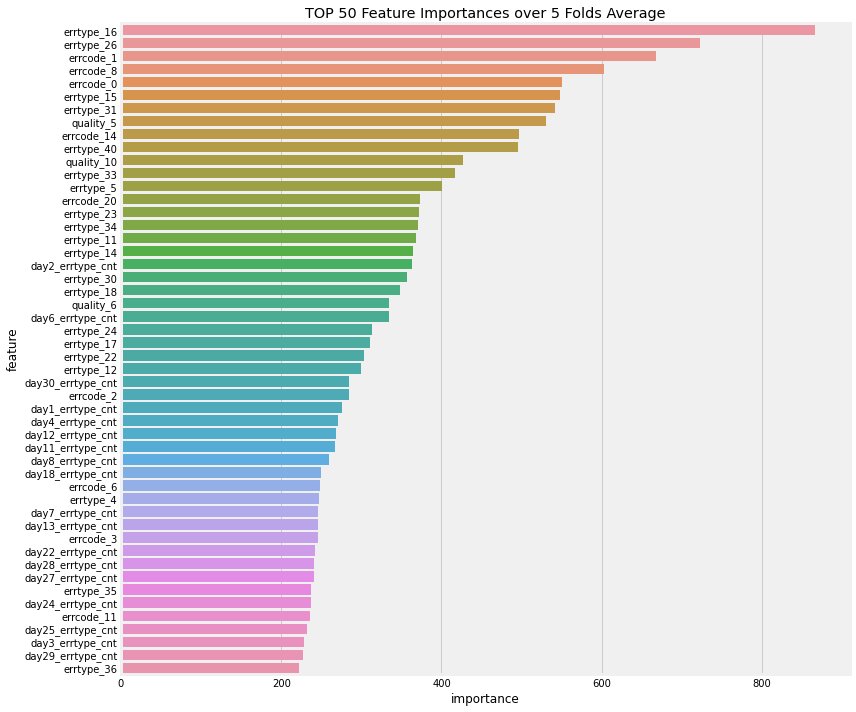

In [211]:
final_importance = feature_importance_df.groupby("feature").mean().sort_values(by="importance", ascending=False).reset_index()[:50]

plt.figure(figsize=(12,10))
sns.barplot(x="importance",y="feature",data=final_importance)
plt.title('TOP 50 Feature Importances over 5 Folds Average')
plt.tight_layout()

### Optimization

In [138]:
from bayes_opt import BayesianOptimization

In [139]:
train_data = lgb.Dataset(train_x, train_y)

In [146]:
def lgb_eval(num_leaves, 
             feature_fraction, 
             bagging_fraction,
             max_depth , 
             min_split_gain, 
             min_child_weight,
#              drop_rate,
             reg_alpha,
             reg_lambda):
    params = {
        'boosting_type': 'gbdt',
        'objective': 'binary',
        'metric': 'auc',
        'learning_rate':0.01,
        'verbose':-1,
        'seed': 42
        }
    params['feature_fraction'] = max(min(feature_fraction, 1), 0)
    params['bagging_fraction'] = max(min(bagging_fraction, 1), 0)
    params['max_depth'] = int(round(max_depth))
    params['num_leaves'] = int(round(num_leaves))
    params['min_split_gain'] = min_split_gain
    params['min_child_weight'] = min_child_weight
#     params['drop_rate']: drop_rate
    params['reg_alpha']: reg_alpha
    params['reg_lambda']: reg_lambda
        
    cv_result = lgb.cv(params, train_data, nfold=3, seed=42, early_stopping_rounds=50, stratified=True)
    
    return cv_result['auc-mean'][-1]

In [147]:
lgbBO = BayesianOptimization(lgb_eval, {'feature_fraction': (0.1, 0.9),
                                        'bagging_fraction': (0.1, 0.9),
                                        'max_depth': (5, 9),
                                        'num_leaves' : (15, 300),
                                        'min_split_gain': (0.001, 1),
                                        'min_child_weight': (1, 20),
#                                         'drop_rate': (0.1, 0.9),
                                        'reg_alpha':(0, 10),
                                        'reg_lambda':(0, 10)}, random_state=42)

In [148]:
lgbBO.maximize(init_points=5, n_iter=10)

|   iter    |  target   | baggin... | featur... | max_depth | min_ch... | min_sp... | num_le... | reg_alpha | reg_la... |
-------------------------------------------------------------------------------------------------------------------------
|  1        |  0.7998   |  0.3996   |  0.8606   |  7.928    |  12.37    |  0.1569   |  59.46    |  0.5808   |  8.662    |
|  2        |  0.7929   |  0.5809   |  0.6665   |  5.082    |  19.43    |  0.8326   |  75.52    |  1.818    |  1.834    |
|  3        |  0.8022   |  0.3434   |  0.5198   |  6.728    |  6.533    |  0.6122   |  54.76    |  2.921    |  3.664    |
|  4        |  0.7976   |  0.4649   |  0.7281   |  5.799    |  10.77    |  0.5928   |  28.24    |  6.075    |  1.705    |
|  5        |  0.7996   |  0.152    |  0.8591   |  8.863    |  16.36    |  0.3053   |  42.84    |  6.842    |  4.402    |
|  6        |  0.8034   |  0.6765   |  0.5341   |  6.586    |  1.089    |  0.4683   |  49.38    |  9.22     |  9.217    |
|  7        |  0.806    

## Prediction

In [202]:
test_err = pd.read_csv('dataset/test_err_data.csv')
test_err = parallelize_dataframe(test_err, make_datetime, n_cores=8)

### Model_NM

In [203]:
test_modelnm_cnt = test_err.pivot_table(index='user_id', 
                                        columns='model_nm', 
                                        values='date',
                                        aggfunc='count',
                                        fill_value=0).reset_index()

test_modelnm_cnt.columns.name=None

### Error Type

In [204]:
test_errrtype_cnt = test_err.pivot_table(index='user_id', 
                                         columns='errtype', 
                                         values='date', 
                                         aggfunc='count', 
                                         fill_value=0).reset_index()

test_errrtype_cnt.columns.name=None
test_errrtype_cnt.columns = ['user_id'] + ['errtype_' + str(i) for i in range(1, 43) if i!=29]
test_errrtype_cnt.head()

,user_id,errtype_1,errtype_2,errtype_3,errtype_4,errtype_5,errtype_6,errtype_7,errtype_8,errtype_9,...,errtype_33,errtype_34,errtype_35,errtype_36,errtype_37,errtype_38,errtype_39,errtype_40,errtype_41,errtype_42
0,30000,0,0,0,0,62,1,1,0,0,...,16,0,1,3,3,0,2,92,0,2
1,30001,0,0,3,98,3,4,4,0,0,...,0,0,0,0,0,0,0,0,0,0
2,30002,0,0,0,0,79,2,1,0,0,...,16,0,0,1,1,0,14,113,1,2
3,30003,0,0,0,0,107,2,2,0,0,...,4,16,3,1,1,0,0,40,8,0
4,30004,0,0,0,2,6,1,1,0,0,...,11,6,1,1,1,1,0,48,90,0


In [205]:
# ## 유저별 일별 에러타입 합산 코드

test_errtype_cnt_byday = test_err.groupby(['user_id','days'])['errtype'].nunique().reset_index()
test_errtype_cnt_byday = test_errtype_cnt_byday.pivot_table(index='user_id', 
                                                            columns='days',
                                                            values='errtype', 
                                                            fill_value=0).reset_index()

test_errtype_cnt_byday.columns.name=None
test_errtype_cnt_byday.columns = ['user_id'] + ['day{}_errtype_cnt'.format(i) for i in test_errtype_cnt_byday.columns[1:]]
test_errtype_cnt_byday.head()

,user_id,day0_errtype_cnt,day1_errtype_cnt,day2_errtype_cnt,day3_errtype_cnt,day4_errtype_cnt,day5_errtype_cnt,day6_errtype_cnt,day7_errtype_cnt,day8_errtype_cnt,...,day29_errtype_cnt,day30_errtype_cnt,day31_errtype_cnt,day32_errtype_cnt,day33_errtype_cnt,day34_errtype_cnt,day35_errtype_cnt,day39_errtype_cnt,day41_errtype_cnt,day44_errtype_cnt
0,30000,0,9,2,6,0,11,9,13,7,...,11,3,0,0,0,0,0,0,0,0
1,30001,0,6,4,4,4,3,2,11,12,...,4,3,0,0,0,0,0,0,0,0
2,30002,0,9,5,12,5,8,6,11,6,...,6,12,0,0,0,0,0,0,0,0
3,30003,0,2,1,2,1,1,1,0,8,...,3,3,0,0,0,0,0,0,0,0
4,30004,0,3,4,10,6,3,4,5,11,...,9,6,0,0,0,0,0,0,0,0


### Error Code

In [206]:
test_err['errcode_type'] = test_err['errcode'].apply(lambda x: case_errcode(x))

In [207]:
# 유저별 에러코드 합산 코드

test_errcode_cnt = test_err.pivot_table(index='user_id', 
                                     columns='errcode_type', 
                                     values='days', 
                                     aggfunc='count', 
                                     fill_value=0).reset_index()

test_errcode_cnt.columns.name=None
test_errcode_cnt.columns = ['user_id'] + ['errcode_' + str(i) for i in test_errcode_cnt.columns[1:]]
test_errcode_cnt.head()

,user_id,errcode_0,errcode_1,errcode_2,errcode_3,errcode_4,errcode_5,errcode_6,errcode_7,errcode_8,...,errcode_11,errcode_12,errcode_13,errcode_14,errcode_15,errcode_16,errcode_17,errcode_18,errcode_19,errcode_20
0,30000,1251,90,1107,53,0,1,14,141,15,...,4,0,55,5,0,0,9,0,0,4
1,30001,180,98,0,0,0,0,0,0,3,...,0,0,0,0,0,0,0,0,0,3
2,30002,614,186,26,77,0,0,4,7,13,...,6,1,0,3,0,0,0,0,0,4
3,30003,147,91,1,106,0,0,11,1,1,...,0,8,0,1,0,0,0,0,0,4
4,30004,395,193,0,0,74,74,25,5,4,...,3,90,0,5,0,0,6,0,0,3


In [208]:
test_errcode_cnt_byday = test_err.groupby(['user_id','days'])['errcode'].nunique().reset_index()

test_errcode_cnt_byday = test_errcode_cnt_byday.pivot_table(index='user_id', 
                                                            columns='days',
                                                            values='errcode', 
                                                            fill_value=0).reset_index()

test_errcode_cnt_byday.columns.name=None
test_errcode_cnt_byday.columns = ['user_id'] + ['day{}_errcode_cnt'.format(i) for i in test_errcode_cnt_byday.columns[1:]]
test_errcode_cnt_byday.head()

,user_id,day0_errcode_cnt,day1_errcode_cnt,day2_errcode_cnt,day3_errcode_cnt,day4_errcode_cnt,day5_errcode_cnt,day6_errcode_cnt,day7_errcode_cnt,day8_errcode_cnt,...,day29_errcode_cnt,day30_errcode_cnt,day31_errcode_cnt,day32_errcode_cnt,day33_errcode_cnt,day34_errcode_cnt,day35_errcode_cnt,day39_errcode_cnt,day41_errcode_cnt,day44_errcode_cnt
0,30000,0,4,2,2,0,6,5,7,4,...,7,2,0,0,0,0,0,0,0,0
1,30001,0,2,2,2,2,2,1,4,4,...,3,2,0,0,0,0,0,0,0,0
2,30002,0,3,2,5,2,3,2,5,3,...,4,7,0,0,0,0,0,0,0,0
3,30003,0,3,2,2,2,2,2,0,5,...,3,4,0,0,0,0,0,0,0,0
4,30004,0,7,5,8,5,5,5,5,8,...,5,3,0,0,0,0,0,0,0,0


### Quality

In [209]:
test_quality = parallelize_dataframe(test_quality, make_datetime, n_cores=4)

In [210]:
test_quality = test_quality.drop(['quality_3', 'quality_4'], axis=1)

test_quality = test_quality.groupby('user_id').apply(pd.DataFrame.sort_values, 'time').reset_index(drop=True)

for col in quality_col:
    test_quality[col] = test_quality[col].apply(lambda x: string2num(x))

In [211]:
test_quality['model_nm'] = test_quality['fwver'].apply(lambda x: case_fwver(x))

In [212]:
test_avg_quality = test_quality.groupby('user_id')[quality_col].mean().reset_index()
test_avg_quality.head()

,user_id,quality_0,quality_1,quality_2,quality_5,quality_6,quality_7,quality_8,quality_9,quality_10,quality_11,quality_12
0,30000,0.00,0.000,0.00,0.166667,0.416667,5.0,0.0,0.0,2.000000,0.000,0.0
1,30001,2.50,0.250,2.50,71.444444,0.250000,0.0,0.0,0.0,854.333333,0.250,0.0
2,30002,1.25,0.125,1.25,1.233333,0.125000,0.0,0.0,0.0,13.300000,0.125,0.0
3,30003,0.00,0.000,0.00,0.200000,3.666667,44.0,0.0,0.0,2.400000,0.000,0.0
4,30004,2.50,0.250,2.50,0.333333,1.625000,16.5,0.0,0.0,1.000000,0.250,0.0


In [ ]:
# test_avgQ_bymodel = test_quality.pivot_table(index='user_id', 
#                                                columns='model_nm', 
#                                                values=quality_col, 
#                                                aggfunc='mean',
#                                                fill_value=0).reset_index()

# test_avgQ_bymodel.columns = ['{}_{}'.format(i, j) for i, j in test_avgQ_bymodel.columns]
# test_avgQ_bymodel = test_avgQ_bymodel.rename(columns = {'user_id_':'user_id'})
# test_avgQ_bymodel.head()

In [213]:
test_user_Q_cnt = test_quality.groupby('user_id')['date'].nunique().reset_index(name='date_cnt')

bins_label = [i*3 for i in range(12)]
label = [i+1 for i in range(11)]

test_user_Q_cnt ['quality_group'] = pd.cut(test_user_Q_cnt ['date_cnt'], bins=bins_label, labels=label)
test_user_Q_cnt ['quality_group'] = test_user_Q_cnt ['quality_group'].astype('int')
test_user_Q_cnt  = test_user_Q_cnt.drop(['date_cnt'], axis=1)
test_user_Q_cnt.head()

,user_id,quality_group
0,30000,1
1,30001,1
2,30002,3
3,30003,2
4,30004,1


In [ ]:
# a = (test_err
#      .filter(['user_id','date'])
#      .drop_duplicates()
#      .reset_index(drop=True)
#     )

# b = (test_quality
#      .filter(['user_id','date'])
#      .drop_duplicates()
#      .reset_index(drop=True)
#     )

# c = pd.merge(a,b, how='left', on='user_id')

# c['cnt'] = np.where(c['date_x']>c['date_y'], 1, 0)

# c = c.groupby(['user_id', 'date_x'])['cnt'].sum().reset_index(name='prior_Q_cnt')
# c['days'] = c['date_x'].apply(lambda x: (x-min_day).days)

# test_Q_cdf = c.pivot_table(index='user_id', 
#                            columns='days', 
#                            values='prior_Q_cnt', 
#                            fill_value=0).reset_index()

# test_Q_cdf.columns.name = None
# test_Q_cdf.columns = ['user_id'] + ['day{}_Qcdf'.format(col) for col in test_Q_cdf.columns[1:]]

### Total

In [217]:
test_x = pd.merge(test_modelnm_cnt, test_errrtype_cnt, how='left', on='user_id')
test_x = pd.merge(test_x, test_errtype_cnt_byday, how='left', on='user_id')

In [218]:
test_x = pd.merge(test_x, test_errcode_cnt, how='left', on='user_id')
test_x = pd.merge(test_x, test_errcode_cnt_byday, how='left', on='user_id')

In [219]:
# test_x = pd.merge(test_x, test_Q_cdf, how='left', on='user_id')

In [220]:
test_x = pd.merge(test_x, test_avg_quality, how='left', on='user_id')
# test_x = pd.merge(test_x, test_avgQ_bymodel, how='left', on='user_id')

In [221]:
test_x = pd.merge(test_x, test_user_Q_cnt, how='left', on='user_id')
test_x = test_x.fillna(0)
test_x['quality_group'] = test_x['quality_group'].astype('category')

In [222]:
prediction = pd.DataFrame(test_x['user_id'])

In [223]:
case_col = list(set(train_x.columns).difference(set(test_x.columns)))

In [224]:
case_col

[]

In [225]:
for col in case_col:
    test_x[case_col]=0

In [226]:
test_x = test_x[list(train_x.columns)]

In [227]:
test_x.head()

,model_0,model_1,model_2,model_3,model_4,model_5,model_6,model_7,model_8,errtype_1,...,quality_2,quality_5,quality_6,quality_7,quality_8,quality_9,quality_10,quality_11,quality_12,quality_group
0,0,2687,63,0,0,0,0,0,0,0,...,0.00,0.166667,0.416667,5.0,0.0,0.0,2.000000,0.000,0.0,1.0
1,0,0,0,284,0,0,0,0,0,0,...,2.50,71.444444,0.250000,0.0,0.0,0.0,854.333333,0.250,0.0,1.0
2,941,0,0,0,0,0,0,0,0,0,...,1.25,1.233333,0.125000,0.0,0.0,0.0,13.300000,0.125,0.0,3.0
3,371,0,0,0,0,0,0,0,0,0,...,0.00,0.200000,3.666667,44.0,0.0,0.0,2.400000,0.000,0.0,2.0
4,0,623,258,0,0,0,0,0,0,0,...,2.50,0.333333,1.625000,16.5,0.0,0.0,1.000000,0.250,0.0,1.0


In [230]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

oof_lgb = np.zeros((len(train_x)))
lgb_pred = np.zeros((len(test_x)))
feature_importance_df = pd.DataFrame()


for fold_, (trn_idx, val_idx) in enumerate(skf.split(train_x, train_y)):
# for fold_, (trn_idx, val_idx) in enumerate(stratified_group_k_fold(train_x, train_y, groups=groups, k=10)):    
    print('[bold magenta]{} Fold Start![/bold magenta]'.format(fold_+1))
    trn_data = lgb.Dataset(train_x.iloc[trn_idx], label=train_y[trn_idx])
    val_data = lgb.Dataset(train_x.iloc[val_idx], label=train_y[val_idx])
    
    num_round = 5000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=300, early_stopping_rounds = 100)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = train_x.columns
    fold_importance_df["importance"] = clf.feature_importance()
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

    oof_lgb[val_idx] = clf.predict(train_x.iloc[val_idx], num_iteration=clf.best_iteration)    
    lgb_pred += clf.predict(test_x, num_iteration=clf.best_iteration) / 5
    
print('\nCross Validation Is Complete')     
print("CV score: {:<8.5f}".format(roc_auc_score(train_y, oof_lgb)))

Training until validation scores don't improve for 100 rounds
[300]	training's auc: 0.856424	valid_1's auc: 0.810418
[600]	training's auc: 0.872426	valid_1's auc: 0.815739
[900]	training's auc: 0.883077	valid_1's auc: 0.817337
[1200]	training's auc: 0.893856	valid_1's auc: 0.818433
[1500]	training's auc: 0.900617	valid_1's auc: 0.818839
Early stopping, best iteration is:
[1629]	training's auc: 0.902078	valid_1's auc: 0.818994


Training until validation scores don't improve for 100 rounds
[300]	training's auc: 0.851998	valid_1's auc: 0.820914
[600]	training's auc: 0.868093	valid_1's auc: 0.827936
[900]	training's auc: 0.881116	valid_1's auc: 0.83167
[1200]	training's auc: 0.892708	valid_1's auc: 0.832593
[1500]	training's auc: 0.899563	valid_1's auc: 0.83299
Early stopping, best iteration is:
[1657]	training's auc: 0.901676	valid_1's auc: 0.833159


Training until validation scores don't improve for 100 rounds
[300]	training's auc: 0.855687	valid_1's auc: 0.803177
[600]	training's auc: 0.870964	valid_1's auc: 0.810611
[900]	training's auc: 0.882683	valid_1's auc: 0.814805
[1200]	training's auc: 0.894106	valid_1's auc: 0.816856
[1500]	training's auc: 0.900403	valid_1's auc: 0.817527
[1800]	training's auc: 0.902131	valid_1's auc: 0.817689
Early stopping, best iteration is:
[1704]	training's auc: 0.902087	valid_1's auc: 0.817716


Training until validation scores don't improve for 100 rounds
[300]	training's auc: 0.853861	valid_1's auc: 0.8145
[600]	training's auc: 0.870336	valid_1's auc: 0.820055
[900]	training's auc: 0.88168	valid_1's auc: 0.822381
[1200]	training's auc: 0.892533	valid_1's auc: 0.823691
[1500]	training's auc: 0.899629	valid_1's auc: 0.824149
Early stopping, best iteration is:
[1536]	training's auc: 0.900144	valid_1's auc: 0.824227


Training until validation scores don't improve for 100 rounds
[300]	training's auc: 0.856529	valid_1's auc: 0.801645
[600]	training's auc: 0.873442	valid_1's auc: 0.808988
[900]	training's auc: 0.885953	valid_1's auc: 0.811298
[1200]	training's auc: 0.896274	valid_1's auc: 0.812373
Early stopping, best iteration is:
[1161]	training's auc: 0.895159	valid_1's auc: 0.812462


In [231]:
prediction['problem'] = lgb_pred

In [232]:
prediction.head()

,user_id,problem
0,30000,0.904935
1,30001,0.315502
2,30002,0.375491
3,30003,0.809119
4,30004,0.814780


In [233]:
submission = pd.read_csv('dataset/sample_submission.csv')
submission = submission.drop('problem', axis=1)

In [234]:
submission = pd.merge(submission, prediction, how='left', on='user_id')

In [235]:
from datetime import date

today = date.today().strftime("%m-%d")
version=2

submission.to_csv(f'{today}_lgb_baseline_{version}.csv', index=False)

In [ ]:
submission.shape

In [ ]:
submission.head()